In [378]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

perc_test = 0.2
batch_size = 100

# load data and one hot encode some of the non numerical features

df = pd.read_csv("PeerLoanKart_fraud.csv")

df.rename(columns={"Loan Repayment Status": "target"}, inplace=True)
df["target"] = (df["target"]=="Paid")*1
df["ntarget"] = 1 - df["target"]
df = pd.concat((df, pd.get_dummies(df["purpose"], dtype="int")), axis=1)

# Select data and target

features = ['all_other',
            'credit_card',
            'debt_consolidation',
            'educational',
            'home_improvement',
            'major_purchase',
            'small_business',
            'log.annual.inc',
            'fico',
            'delinq.2yrs',
            'pub.rec',
            'credit.policy',
            'int.rate',
            'installment',
            'days.with.cr.line',
            'inq.last.6mths',
            'dti',
            'revol.util',
            'revol.bal',
          ]

target = ['target',
          'ntarget']

X = df[features]
y = df[target]

# Normalize all features that have large deviations

numerical_features = ['log.annual.inc',
                      'fico',
                      'installment',
                      'days.with.cr.line',
                      'dti',
                      'revol.util',
                      'revol.bal',
                      'inq.last.6mths',
          ]

def normalize(X):
    X.loc[:, numerical_features] = (X[numerical_features] - X[numerical_features].mean())/X[numerical_features].std()
    return X

X = normalize(X)

#purposes = ['all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']

#for i, purpose in enumerate(purposes):
#    Xnorm = normalize(X[X[purpose]==1])
#    if i==0:
#        Xcat = Xnorm
#    else:
#        Xcat = pd.concat((Xcat, Xnorm), axis=0)
#X = Xcat


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=perc_test, random_state=123, shuffle=True)

Xt_train = torch.tensor(X_train.values).float()
yt_train = torch.tensor(y_train.values).float()
Xt_test = torch.tensor(X_test.values).float()
yt_test = torch.tensor(y_test.values).float()

train_dataset = TensorDataset(Xt_train, yt_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size)

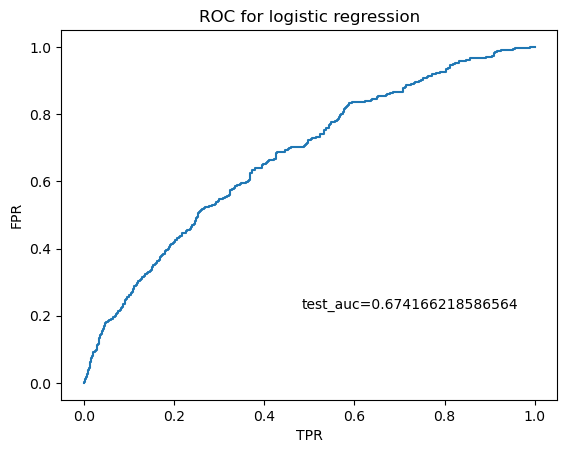

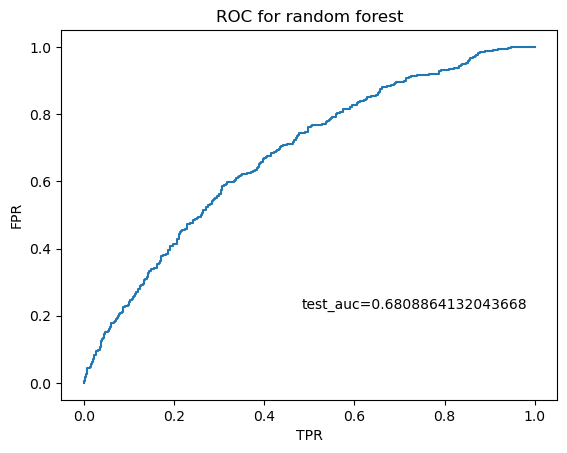

In [379]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

clf = LogisticRegression()
clf.fit(X_train, y_train["target"])

pred = clf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,0])
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for logistic regression")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

clf = RandomForestClassifier(n_estimators=150, max_depth=5)
clf.fit(X_train, y_train["target"])

pred = clf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test["target"], pred[:,0])
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for random forest")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()

In [376]:
import torch
from torch import nn
from torch.nn import functional as F

dropout = 0.1

class SimpleNeuralNet(nn.Module):

    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.dropout1 = nn.Dropout(dropout)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.dropout2 = nn.Dropout(dropout)
        self.output = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = self.dropout1(F.relu(self.hidden1(x)))
        x = x + self.dropout2(F.sigmoid(self.hidden2(x)))
        x = F.softmax(self.output(x), dim=1)
        return x

nnet = SimpleNeuralNet(n_input=19, n_hidden1=8, n_hidden2=8, n_output=2)

optimizer = torch.optim.AdamW(params = nnet.parameters(), lr= 1e-3, weight_decay=1e-3, eps=1e-7)
loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]))

n_epochs = 20
N_print = 50

nnet.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (features, target) in enumerate(train_loader, 0):

        optimizer.zero_grad()
        p_train = nnet(features)
        loss = loss_func(p_train, target)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % N_print == (N_print-1):
            print(i, running_loss/N_print)
            running_loss = 0.0

49 0.788738077878952
49 0.6985903358459473
49 0.6740796959400177
49 0.6667414283752442
49 0.6633693397045135
49 0.6592684614658356
49 0.6575742816925049
49 0.6546874809265136
49 0.6549307072162628
49 0.6525248539447784
49 0.6519092881679535
49 0.652211811542511
49 0.6514201426506042
49 0.6502581405639648
49 0.6509665477275849
49 0.6512230849266052
49 0.6505928456783294
49 0.6509780073165894
49 0.6496306312084198
49 0.649080286026001


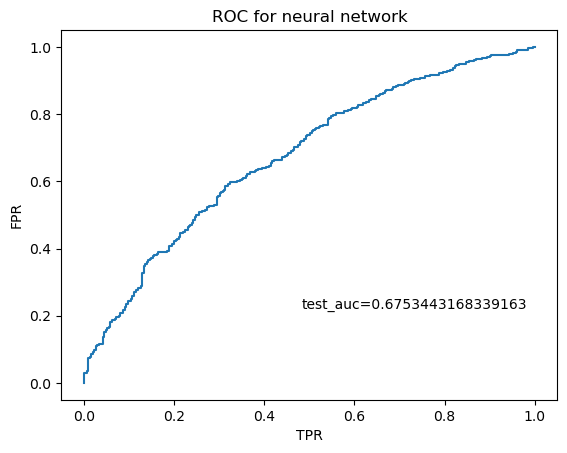

In [377]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

nnet.eval()
p_test = nnet(Xt_test)

y_true = yt_test[:,-1].detach().numpy()
y_score = p_test[:,0].detach().numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_score)
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr, fpr)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC for neural network")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.show()